In [1]:
# Tại bên này có nhiều version, bỏ qua
import sys
print(sys.executable)
assert str(sys.executable) == 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python38\\python.exe'

C:\Users\user\AppData\Local\Programs\Python\Python38\python.exe


In [211]:
from pandas_datareader import data as pdr
import datetime
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from requests_html import HTML
import time

%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import numpy as np
import math


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Get data with Crawler

In [212]:
row_id = []
for i in range(1, 21):
    if i%2: row_id.append(str(i).zfill(2) + '_')
    else: row_id.append(str(i).zfill(2) + '_alt')

def get_stock_data(stock_symbol, output_file):
    url = 'https://s.cafef.vn/Lich-su-giao-dich-' + stock_symbol + '-1.chn'    
    
    file = open(output_file, 'w', encoding='utf-8')
    file.write(f'Date,Open,High,Low,Close\n')

    driver = webdriver.Chrome(executable_path='./chromedriver.exe')
    driver.get(url)
    html = HTML(html=driver.page_source)

    while True:
        for i in row_id:
            row = html.find('tr#ctl00_ContentPlaceHolder1_ctl03_rptData2_ctl' + i + 'itemTR', first=True)
            if row:
                date = row.find('td.Item_DateItem', first=True).text
                prices = row.find('td.Item_Price10')
                op, hi, lo, cl = prices[5].text, prices[6].text, prices[7].text, prices[1].text
                file.write(f'{date},{op},{hi},{lo},{cl}\n')

        button = driver.find_elements(By.LINK_TEXT, '>')
        if len(button) > 0:
            button[0].click()
            time.sleep(2)
        else:
            break

    file.close()

In [213]:
stock = ['BVH', 'SSI', 'HDG']

In [ ]:
for symbol in stock:
    get_stock_data(symbol, symbol+'.csv')

In [27]:
def SaveData(df, filename):
    df.to_csv('./data/' + filename + '.csv')

def getData(ticker):
    print('Getting', ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    SaveData(data, ticker)

In [67]:
start_date = "2000-01-01"
end_date = "2020-12-15"

ticker_list = ['GOOG', 'AAPL']

for tik in ticker_list:
    if not os.path.isfile('./data/' + tik + '.csv'):
        getData(tik)
    else:
        print(tik, 'data existed.')

Getting GOOG
[*********************100%***********************]  1 of 1 completed
Getting AAPL
[*********************100%***********************]  1 of 1 completed


GOOG


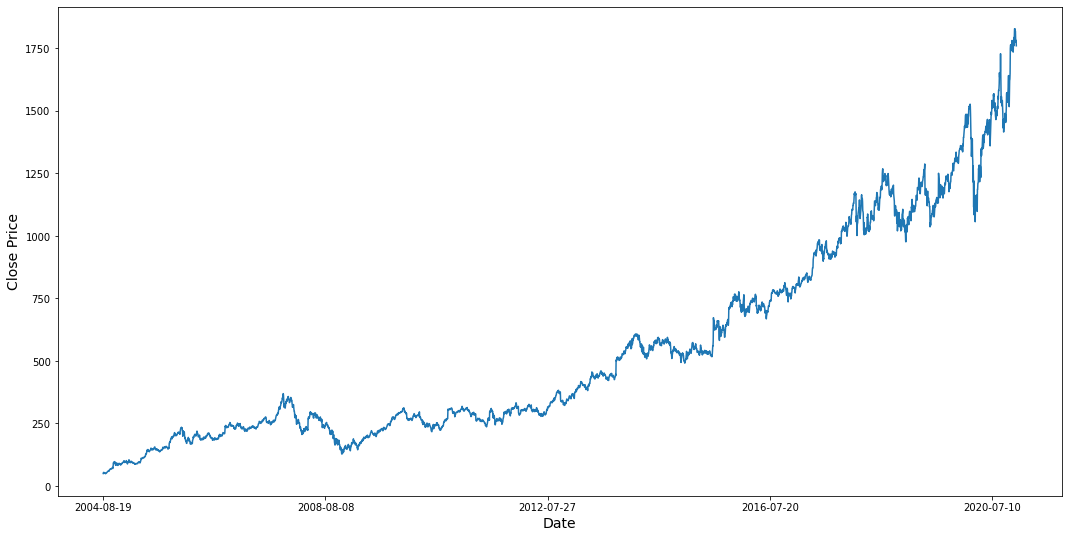

AAPL


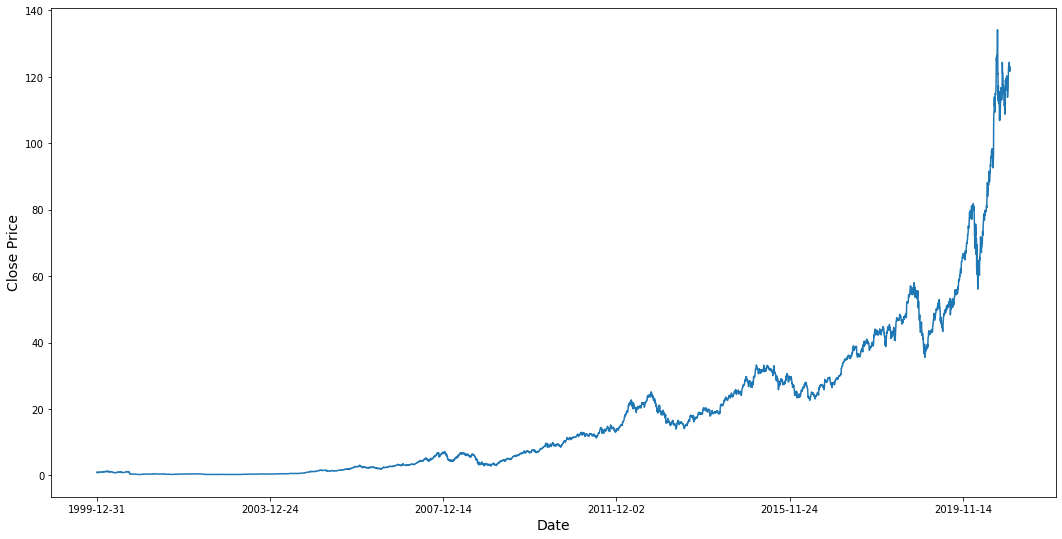

In [69]:
for s in ticker_list:
    print(s)
    df= pd.read_csv('./data/' + s + '.csv', index_col='Date')
    
    
    
    plt.figure(figsize = (18,9))
    df['Close'].plot()
    
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Close Price',fontsize=14)
    
    plt.show()

# Forecasting

In [186]:
goog = pd.read_csv('./data/' + 'GOOG' + '.csv', parse_dates={'Datetime':['Date']})
goog.set_index(['Datetime'], inplace = True)
goog.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


## Scaling and split data

### Scaling

In [187]:
# Lấy 80% đầu tiên làm tập train, dữ liệu time series ko có split random đc
split_threshold = math.ceil(len(goog['Close'])*0.8)
# 100 ngày trước i -> x, ra kết quả y -> ngày thứ i (ngày thứ 61)
time_window = 100

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(goog['Close'].to_numpy().reshape(-1, 1))

train = scaled_data[:split_threshold]
test = scaled_data[split_threshold - time_window:] # Test cần lấy n ngày trước để tạo x_test cho valid[0]

train.shape, test.shape, scaled_data.shape

((3288, 1), (922, 1), (4110, 1))

### Create x_train and y_train datasets

In [188]:
x_train = []
y_train = []

for i in range(time_window, len(train)):
    x_train.append(train[i-time_window:i,0])
    y_train.append(train[i,0])
    
    #if i == 101:
        #print(x_train)
        #print(y_train)
    
x_train = np.reshape(np.array(x_train), (len(x_train), time_window, 1))
y_train = np.array(y_train)

In [189]:
x_train.shape, y_train.shape

((3188, 100, 1), (3188,))

## Build LSTM model

In [118]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [119]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

3188/3188 [==============================] - 103s 32ms/step - loss: 3.2055e-040s - loss:


## Create test dataset

In [133]:
x_test = []
y_test =  scaled_data[split_threshold:]
for i in range(time_window, len(test)):
    x_test.append(test[i-time_window:i,0])
    
x_test = np.reshape(np.array(x_test), (len(x_test), time_window, 1))
    
x_test.shape, y_test.shape

((822, 100, 1), (822, 1))

## Prediction

In [134]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) #Từ scaled -> giá trị cũ

In [203]:
train_data = goog[:split_threshold]
valid_data = goog[split_threshold:]
valid_data['Prediction'] = predictions

<ipython-input-203-766a34a065c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Prediction'] = predictions


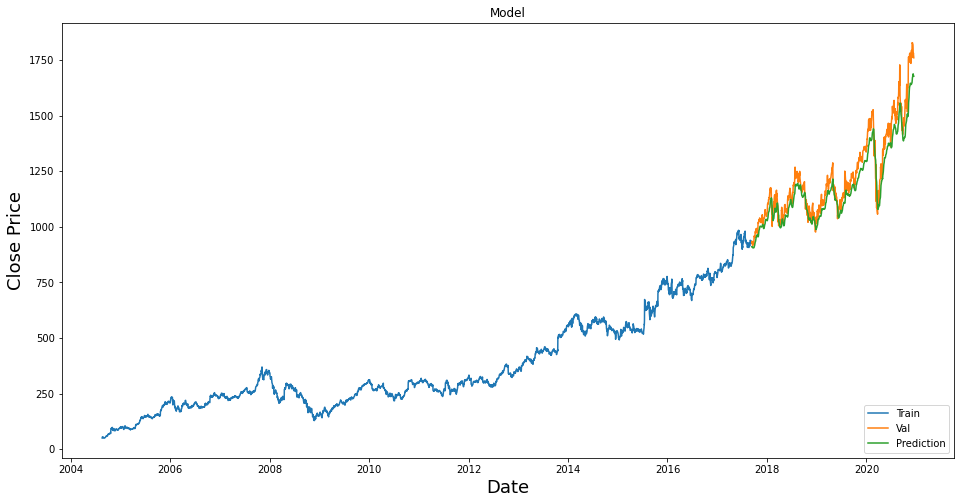

In [207]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Prediction'], loc='lower right')
plt.show()

In [194]:
train_data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...
2017-09-01,941.130005,942.479980,935.150024,937.340027,937.340027,947400
2017-09-05,933.080017,937.000000,921.960022,928.450012,928.450012,1326400
2017-09-06,930.150024,930.914978,919.270020,927.809998,927.809998,1527700


In [154]:
valid_data

Date
2017-09-11     929.080017
2017-09-12     932.070007
2017-09-13     935.090027
2017-09-14     925.109985
2017-09-15     920.289978
                 ...     
2020-12-08    1818.550049
2020-12-09    1784.130005
2020-12-10    1775.329956
2020-12-11    1781.770020
2020-12-14    1760.060059
Name: Close, Length: 822, dtype: float64

In [135]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1192.7089697624513

# Ref

https://insights.magestore.com/posts/giai-thuat-time-series-forecasting
https://www.datacamp.com/community/tutorials/lstm-python-stock-market
https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb
https://viblo.asia/p/lam-quen-voi-keras-gGJ59mxJ5X2

In [168]:
#Get the stock quote 
df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 
#Show the data 
df.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-01-03  14.621428  14.732142  14.607142  14.686786  12.566676  302220800
2012-01-04  14.642858  14.810000  14.617143  14.765715  12.634213  260022000
2012-01-05  14.819643  14.948215  14.738214  14.929643  12.774481  271269600
2012-01-06  14.991786  15.098214  14.972143  15.085714  12.908023  318292800
2012-01-09  15.196428  15.276786  15.048214  15.061786  12.887549  394024400
...               ...        ...        ...        ...        ...        ...
2019-12-10  67.150002  67.517502  66.464996  67.120003  66.004898   90420400
2019-12-11  67.202499  67.775002  67.125000  67.692497  66.567886   78756800
2019-12-12  66.945000  68.139999  66.830002  67.864998  66.737518  137310400
2019-12-13  67.864998  68.824997  67.732498  68.787498  67.644707  133587600
2019-12-16  69.250000  70.197502  69.245003  6

In [170]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621428,14.732142,14.607142,14.686786,12.566676,302220800
2012-01-04,14.642858,14.810000,14.617143,14.765715,12.634213,260022000
2012-01-05,14.819643,14.948215,14.738214,14.929643,12.774481,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.908023,318292800
2012-01-09,15.196428,15.276786,15.048214,15.061786,12.887549,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,66.004898,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.567886,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.737518,137310400


In [171]:
goog

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...
2020-12-08,1810.099976,1821.900024,1796.204956,1818.550049,1818.550049,1096300
2020-12-09,1812.010010,1834.270020,1767.810059,1784.130005,1784.130005,1507600
2020-12-10,1769.800049,1781.310059,1740.319946,1775.329956,1775.329956,1362800


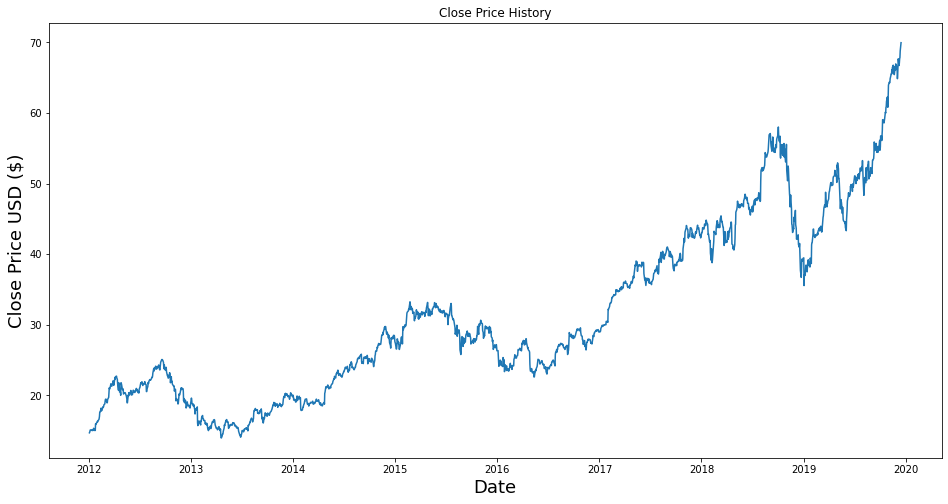

In [174]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [175]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [176]:
type(goog.index)

pandas.core.indexes.base.Index